In [1]:
import tensorflow as tf
print(tf.__version__)


gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]
)

2.3.1


# Saving and loading models

 ## Coding tutorials
 #### [1. Saving and loading model weights](#coding_tutorial_1)
 #### [2. Model saving criteria](#coding_tutorial_2)
 #### [3. Saving the entire model](#coding_tutorial_3)
 #### [4. Loading pre-trained Keras models](#coding_tutorial_4)
 #### [5. Tensorflow Hub modules](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Saving and loading model weights

#### Load and inspect CIFAR-10 dataset

The CIFAR-10 dataset consists of, in total, 60000 color images, each with one of 10 labels: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. For an introduction and a download, see [this link](https://www.cs.toronto.edu/~kriz/cifar.html).

In [45]:
# Import the CIFAR-10 dataset and rescale the pixel values

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# Use smaller subset -- speeds things up
x_train = x_train[:10000]
y_train = y_train[:10000]
x_test = x_test[:1000]
y_test = y_test[:1000]

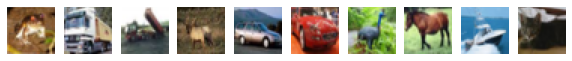

In [3]:
# Plot the first 10 CIFAR-10 images

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(x_train[i])

#### Introduce two useful functions

In [4]:
# Introduce function to test model accuracy

def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

In [5]:
# Introduce function that creates a new instance of a simple CNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

def get_new_model():
    model = Sequential([
        Conv2D(filters=16, input_shape=(32, 32, 3), kernel_size=(3, 3), 
               activation='relu', name='conv_1'),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(4, 4), name='pool_1'),
        Flatten(name='flatten'),
        Dense(units=32, activation='relu', name='dense_1'),
        Dense(units=10, activation='softmax', name='dense_2')
    ])
#     model.compile(optimizer='adam',
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=[tf.metrics.SparseCategoricalAccuracy()])
    return model

#### Create simple convolutional neural network classifier

In [6]:
# Create an instance of the model and show model summary

model = get_new_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 8)         1160      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 7, 7, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 392)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                12576     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 14,514
Trainable params: 14,514
Non-trainable params: 0
____________________________________________________

In [7]:
# Test accuracy of the untrained model, around 10% (random)

get_test_accuracy(model, x_test, y_test)

accuracy: 0.103


#### Train model with checkpoints

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [9]:
import os
# Create Tensorflow checkpoint object
checkpoint_dir = "./model_checkpoints"
checkpoint_path = os.path.join(checkpoint_dir, "weights.{epoch:02d}")
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [10]:
# Fit model, with simple checkpoint which saves (and overwrites) model weights every epoch

model = get_new_model()
model.fit(
    x_train,
    y_train,
    epochs=3,
    validation_split=0.15,
    callbacks=[cp_callback])

Epoch 1/3
266/266 [==============================] - ETA: 0s - loss: 2.0507 - sparse_categorical_accuracy: 0.2382
Epoch 00001: saving model to ./model_checkpoints/weights.01
266/266 [==============================] - 1s 4ms/step - loss: 2.0507 - sparse_categorical_accuracy: 0.2382 - val_loss: 1.8791 - val_sparse_categorical_accuracy: 0.3280
Epoch 2/3
256/266 [===========================>..] - ETA: 0s - loss: 1.6984 - sparse_categorical_accuracy: 0.3844
Epoch 00002: saving model to ./model_checkpoints/weights.02
266/266 [==============================] - 1s 3ms/step - loss: 1.6924 - sparse_categorical_accuracy: 0.3855 - val_loss: 1.6480 - val_sparse_categorical_accuracy: 0.3880
Epoch 3/3
260/266 [============================>.] - ETA: 0s - loss: 1.5399 - sparse_categorical_accuracy: 0.4459
Epoch 00003: saving model to ./model_checkpoints/weights.03
266/266 [==============================] - 1s 3ms/step - loss: 1.5376 - sparse_categorical_accuracy: 0.4468 - val_loss: 1.5282 - val_sparse_

In [11]:
# Have a look at what the checkpoint creates

! ls -lh {checkpoint_dir}
! cat {checkpoint_dir}/checkpoint

total 544K
-rw-r--r--. 1 root root   77 Nov 18 06:09 checkpoint
-rw-r--r--. 1 root root 174K Nov 18 06:09 weights.01.data-00000-of-00001
-rw-r--r--. 1 root root 2.0K Nov 18 06:09 weights.01.index
-rw-r--r--. 1 root root 174K Nov 18 06:09 weights.02.data-00000-of-00001
-rw-r--r--. 1 root root 2.0K Nov 18 06:09 weights.02.index
-rw-r--r--. 1 root root 174K Nov 18 06:09 weights.03.data-00000-of-00001
-rw-r--r--. 1 root root 2.0K Nov 18 06:09 weights.03.index
drwxr-xr-x. 4 root root   59 Nov 18 05:53 weights_01
drwxr-xr-x. 4 root root   59 Nov 18 05:53 weights_02
drwxr-xr-x. 4 root root   59 Nov 18 05:54 weights_03
drwxr-xr-x. 4 root root   59 Nov 18 05:54 weights_04
drwxr-xr-x. 4 root root   59 Nov 18 05:54 weights_06
model_checkpoint_path: "weights.03"
all_model_checkpoint_paths: "weights.03"


In [12]:
# Evaluate the performance of the trained model
get_test_accuracy(model, x_test, y_test)

accuracy: 0.459


#### Create new model, load weights

In [13]:
# Create a new instance of the (initialised) model, accuracy around 10% again

model = get_new_model()
get_test_accuracy(model, x_test, y_test)

accuracy: 0.095


In [14]:
# Load weights -- accuracy is the same as the trained model
model.load_weights(os.path.join(checkpoint_dir, "weights.03"))
get_test_accuracy(model, x_test, y_test)


accuracy: 0.459


#### Clear directory

In [15]:
! rm -r {checkpoint_dir}

***
<a id="coding_tutorial_2"></a>
## Model saving criteria

#### Create more customised checkpoint

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [17]:
# Create Tensorflow checkpoint object with epoch and batch details

checkpoint_path = "model_checkpoints_5000/weights_{epoch:02d}"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_freq=500,
                                                 verbose=1)

In [18]:
# Create and fit model with checkpoint

model = get_new_model()
model.fit(
    x_train,
    y_train,
    epochs=3,
    batch_size=10,
    validation_split=0.15,
    callbacks=[cp_callback])

Epoch 1/3
477/850 [===============>..............] - ETA: 0s - loss: 2.0119 - sparse_categorical_accuracy: 0.2595
Epoch 00001: saving model to model_checkpoints_5000/weights_01
850/850 [==============================] - 2s 3ms/step - loss: 1.8849 - sparse_categorical_accuracy: 0.3076 - val_loss: 1.6797 - val_sparse_categorical_accuracy: 0.3967
Epoch 2/3
136/850 [===>..........................] - ETA: 1s - loss: 1.6114 - sparse_categorical_accuracy: 0.4213
Epoch 00002: saving model to model_checkpoints_5000/weights_02
629/850 [=====================>........] - ETA: 0s - loss: 1.5602 - sparse_categorical_accuracy: 0.4328
Epoch 00002: saving model to model_checkpoints_5000/weights_02
850/850 [==============================] - 2s 3ms/step - loss: 1.5359 - sparse_categorical_accuracy: 0.4394 - val_loss: 1.5142 - val_sparse_categorical_accuracy: 0.4413
Epoch 3/3
277/850 [========>.....................] - ETA: 1s - loss: 1.4441 - sparse_categorical_accuracy: 0.4794
Epoch 00003: saving model t

In [19]:
# Have a look at what the checkpoint creates


! ls -lh model_checkpoints_5000

total 544K
-rw-r--r--. 1 root root   77 Nov 18 06:09 checkpoint
-rw-r--r--. 1 root root 174K Nov 18 06:09 weights_01.data-00000-of-00001
-rw-r--r--. 1 root root 2.0K Nov 18 06:09 weights_01.index
-rw-r--r--. 1 root root 174K Nov 18 06:09 weights_02.data-00000-of-00001
-rw-r--r--. 1 root root 2.0K Nov 18 06:09 weights_02.index
-rw-r--r--. 1 root root 174K Nov 18 06:09 weights_03.data-00000-of-00001
-rw-r--r--. 1 root root 2.0K Nov 18 06:09 weights_03.index


#### Work with model saving criteria

In [30]:
# Use tiny training and test set -- will overfit!

x_train = x_train[:100]
y_train = y_train[:100]
x_test = x_test[:100]
y_test = y_test[:100]

In [31]:
# Create a new instance of untrained model

model = get_new_model()

In [32]:
# Create Tensorflow checkpoint object which monitors the validation accuracy
! rm -r model_checkpoints_best
! mkdir model_checkpoints_best
checkpoint_path = "./model_checkpoints_best/weights_{epoch:02d}"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_sparse_categorical_accuracy',
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)

In [33]:
# Fit the model and save only the weights with the highest validation accuracy

history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=10,
    validation_data=(x_test, y_test),
    verbose=0,
    callbacks=[cp_callback])
get_test_accuracy(model, x_test, y_test)


Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.13000, saving model to ./model_checkpoints_best/weights_01

Epoch 00002: val_sparse_categorical_accuracy did not improve from 0.13000

Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.13000

Epoch 00004: val_sparse_categorical_accuracy did not improve from 0.13000

Epoch 00005: val_sparse_categorical_accuracy did not improve from 0.13000

Epoch 00006: val_sparse_categorical_accuracy did not improve from 0.13000

Epoch 00007: val_sparse_categorical_accuracy did not improve from 0.13000

Epoch 00008: val_sparse_categorical_accuracy did not improve from 0.13000

Epoch 00009: val_sparse_categorical_accuracy did not improve from 0.13000

Epoch 00010: val_sparse_categorical_accuracy did not improve from 0.13000
accuracy: 0.070


loss
sparse_categorical_accuracy
val_loss
val_sparse_categorical_accuracy


<AxesSubplot:>

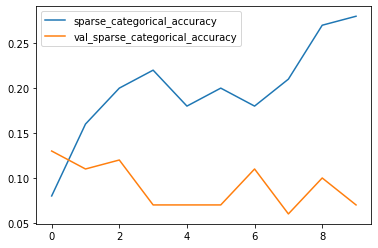

In [34]:
# Plot training and testing curves

import pandas as pd
for key in history.history:
    print(key)
df = pd.DataFrame(history.history)
df.plot(y=['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy'])

In [35]:
# Inspect the checkpoint directory

! ls -lh model_checkpoints_best

total 184K
-rw-r--r--. 1 root root   77 Nov 18 06:10 checkpoint
-rw-r--r--. 1 root root 174K Nov 18 06:10 weights_01.data-00000-of-00001
-rw-r--r--. 1 root root 2.0K Nov 18 06:10 weights_01.index


In [37]:
# Create a new model with the saved weights
get_test_accuracy(model, x_test, y_test)
del model 

model = get_new_model()
model.load_weights( "model_checkpoints_best/weights_01")

get_test_accuracy(model, x_test, y_test)

accuracy: 0.100
accuracy: 0.130


#### Clear directory

In [38]:
! rm -r model_checkpoints_5000 model_checkpoints_best

***
<a id="coding_tutorial_3"></a>
## Saving the entire model

#### Create checkpoint that saves whole model, not just weights

In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [46]:
# Create Tensorflow checkpoint object

# Create Tensorflow checkpoint object which monitors the validation accuracy
! rm -r model_checkpoints
checkpoint_path = "./model_checkpoints"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_sparse_categorical_accuracy',
                                                 save_best_only=True,
                                                 verbose=1)

In [47]:
# Create and fit model with checkpoint

model = get_new_model()
history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=10,
    validation_data=(x_test, y_test),
    verbose=0,
    callbacks=[cp_callback])




Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.44400, saving model to ./model_checkpoints
INFO:tensorflow:Assets written to: ./model_checkpoints/assets

Epoch 00002: val_sparse_categorical_accuracy improved from 0.44400 to 0.46700, saving model to ./model_checkpoints
INFO:tensorflow:Assets written to: ./model_checkpoints/assets

Epoch 00003: val_sparse_categorical_accuracy improved from 0.46700 to 0.49200, saving model to ./model_checkpoints
INFO:tensorflow:Assets written to: ./model_checkpoints/assets

Epoch 00004: val_sparse_categorical_accuracy improved from 0.49200 to 0.50900, saving model to ./model_checkpoints
INFO:tensorflow:Assets written to: ./model_checkpoints/assets

Epoch 00005: val_sparse_categorical_accuracy improved from 0.50900 to 0.51900, saving model to ./model_checkpoints
INFO:tensorflow:Assets written to: ./model_checkpoints/assets

Epoch 00006: val_sparse_categorical_accuracy improved from 0.51900 to 0.55300, saving model to ./model_checkpoin

#### Inspect what the checkpoint has created

In [48]:
# Have a look at what the checkpoint creates

! ls -lh model_checkpoints

total 124K
drwxr-xr-x. 2 root root    6 Nov 18 06:14 assets
-rw-r--r--. 1 root root 121K Nov 18 06:15 saved_model.pb
drwxr-xr-x. 2 root root   66 Nov 18 06:15 variables


In [49]:
# Enter variables directory
! ls -lh model_checkpoints/variables

total 184K
-rw-r--r--. 1 root root 177K Nov 18 06:15 variables.data-00000-of-00001
-rw-r--r--. 1 root root 2.2K Nov 18 06:15 variables.index


In [50]:
# Get the model's test accuracy
get_test_accuracy(model, x_test, y_test)


accuracy: 0.565


#### Create new model from scratch

In [51]:
# Delete model
del model


In [52]:
from tensorflow.keras.models import load_model

In [53]:
# Reload model from scratch
model = tf.keras.models.load_model('model_checkpoints')
get_test_accuracy(model, x_test, y_test)

accuracy: 0.565


#### Use the .h5 format to save model

In [54]:
# Save the model in .h5 format

model.save('my_model.h5')

In [56]:
# Inspect .h5 file

! ls -lh my_model.h5

-rw-r--r--. 1 root root 77K Nov 18 06:17 my_model.h5


In [ ]:
# Delete model

del model

In [58]:
# Reload model from scratch

model = tf.keras.models.load_model('my_model.h5')
get_test_accuracy(model, x_test, y_test)

accuracy: 0.565


#### Clear directory

In [59]:
! rm -r model_checkpoints
! rm my_model.h5

***
<a id="coding_tutorial_4"></a>
## Loading pre-trained Keras models

#### Import and build Keras ResNet50 model

Today we'll be using the ResNet50 model designed by a team at Microsoft Research, available through Keras applications. Please see the description on the [Keras applications page](https://keras.io/applications/#resnet) for details. If you continue using it, please cite it properly! The paper it comes from is:

Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. "Deep Residual Learning for Image Recognition", 2015.

This model takes a long time to download on the Coursera platform, so it is pre-downloaded in your workspace and saved in Keras HDF5 format. If you want to import it on your personal machine, use the following code:

```python
from tensorflow.keras.applications import ResNet50
model = ResNet50(weights='imagenet')
```

In this coding tutorial, you will instead load the model directly from disk.

In [ ]:
from tensorflow.keras.models import load_model

In [60]:
# Build Keras ResNet50 model

from tensorflow.keras.applications import ResNet50
model = ResNet50(weights='imagenet')


102973440/102967424 [==============================] - 14s 0us/step


In [61]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

#### Import and preprocess 3 sample images

In [62]:
# Import 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img('images/lemon.jpg', target_size=(224, 224))
viaduct_img = load_img('images/viaduct.jpg', target_size=(224, 224))
water_tower_img = load_img('images/water_tower.jpg', target_size=(224, 224))

#### Use ResNet50 model to classify images

In [63]:
# Useful function: presents top 5 predictions and probabilities

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...]
    x = preprocess_input(x)
    preds = decode_predictions(model.predict(x), top=5)
    top_preds = pd.DataFrame(columns=['prediction', 'probability'],
                             index=np.arange(5)+1)
    for i in range(5):
        top_preds.loc[i+1, 'prediction'] = preds[0][i][1]
        top_preds.loc[i+1, 'probability'] = preds[0][i][2] 
    return top_preds

##### Image 1: lemon

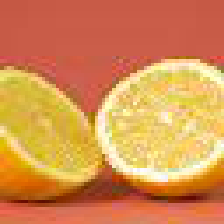

In [72]:
lemon_img

In [73]:
# Display top 5 predictions
get_top_5_predictions(lemon_img)

,prediction,probability
1,consomme,0.227801
2,lemon,0.221758
3,eggnog,0.151335
4,ladle,0.0400883
5,spotlight,0.0291972


##### Image 2: viaduct

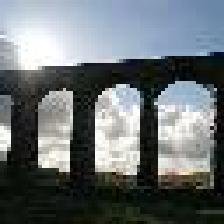

In [74]:
# Display image

viaduct_img

In [76]:
# Display top 5 predictions

get_top_5_predictions(viaduct_img)

,prediction,probability
1,vault,0.367951
2,prison,0.111742
3,viaduct,0.110738
4,window_screen,0.0882308
5,fire_screen,0.0206752


##### Image 3: water tower

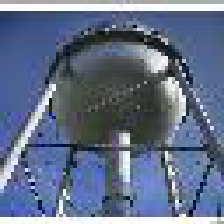

In [77]:
# Display image
water_tower_img


In [78]:
# Display top 5 predictions

get_top_5_predictions(water_tower_img)

,prediction,probability
1,solar_dish,0.384681
2,ladle,0.196179
3,planetarium,0.116682
4,strainer,0.0499902
5,jigsaw_puzzle,0.0219473


***
<a id="coding_tutorial_5"></a>
## Tensorflow Hub modules

#### Import and build Tensorflow Hub MobileNet v1 model

Today we'll be using Google's MobileNet v1 model, available on Tensorflow Hub. Please see the description on the [Tensorflow Hub page](https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4) for details on it's architecture, how it's trained, and the reference. If you continue using it, please cite it properly! The paper it comes from is:

Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitry Kalenichenko, Weijun Wang, Tobias Weyand, Marco Andreetto, Hartwig Adam: "MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications", 2017.

This model takes a long time to download on the Coursera platform, so it is pre-downloaded in your workspace and saved in Tensorflow SavedModel format. If you want to import it on your personal machine, use the following code:

```python
module_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"
model = Sequential([hub.KerasLayer(module_url)])
model.build(input_shape=[None, 160, 160, 3])
```

In this coding tutorial, you will instead load the model directly from disk.

In [79]:
import tensorflow_hub as hub
from tensorflow.keras.models import load_model

In [89]:
# Build Google's Mobilenet v1 model

module_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"
model = tf.keras.models.Sequential([hub.KerasLayer(module_url)])
model.build(input_shape=[None, 160, 160, 3])
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              1343049   
Total params: 1,343,049
Trainable params: 0
Non-trainable params: 1,343,049
_________________________________________________________________


#### Use MobileNet model to classify images

In [108]:
# Import and preprocess 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img("images/lemon.jpg", target_size=(160, 160))
viaduct_img = load_img("images/viaduct.jpg", target_size=(160, 160))
water_tower_img = load_img("images/water_tower.jpg", target_size=(160, 160))

In [109]:
# Read in categories text file

with open('images/imagenet_categories.txt') as txt_file:
    categories = txt_file.read().splitlines()
len(categories)

1001

In [116]:
# Useful function: presents top 5 predictions

import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...] / 255.0
    preds = model.predict(x)
    top_preds = pd.DataFrame(columns=['prediction'],
                             index=np.arange(5)+1)
    sorted_index = np.argsort(-preds[0])
    for i in range(5):
        ith_pred = categories[sorted_index[i]]
        top_preds.loc[i+1, 'prediction'] = ith_pred
            
    return top_preds


##### Image 1: lemon

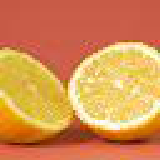

In [117]:
lemon_img

In [118]:
get_top_5_predictions(lemon_img)

,prediction
1,shower cap
2,tray
3,candle
4,brassiere
5,African chameleon


##### Image 2: viaduct

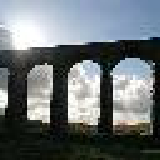

In [119]:
viaduct_img

In [120]:
get_top_5_predictions(viaduct_img)

,prediction
1,viaduct
2,pier
3,dam
4,prison
5,solar dish


##### Image 3: water tower

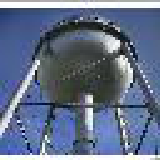

In [121]:
water_tower_img

In [122]:
get_top_5_predictions(water_tower_img)

,prediction
1,solar dish
2,water tower
3,aircraft carrier
4,jigsaw puzzle
5,oxygen mask
